In [2]:
import torchvision
from torchvision import transforms
import torch
from torch import no_grad

In [4]:
# Library for getting data from the web
import requests

In [5]:
# Libraries for image processing and visualization
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [38]:
def get_predictions(pred, threshold=0.8, objects=None):
    """
    This function will assign a string name to a predicted class and eliminate predictions whose likelihood  is under a threshold 
    
    pred: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class yhat, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    image : frozen surface
    predicted_classes: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    thre
    """
    predicted_classes = [(COCO_INSTANCE_CATEGORY_NAMES[i],p,[(box[0], box[1]), (box[2], box[3])]) for i,p,box in zip(list(pred[0]['labels'].numpy()),pred[0]['scores'].detach().numpy(),list(pred[0]['boxes'].detach().numpy()))]
    predicted_classes=[  stuff  for stuff in predicted_classes  if stuff[1]>threshold ]

    if objects and predicted_classes:
        predicted_classes = [ (name, p, box) for name, p, box in predicted_classes if name in  objects ]
    return predicted_classes

In [59]:
def draw_box(predicted_classes,image,rect_th= 10,text_size= 3,text_th=3):
    """
    draws box around each object 
    
    predicted_classes: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    image : frozen surface 
   
    """

    img=(np.clip(cv2.cvtColor(np.clip(image.numpy().transpose((1, 2, 0)),0,1), cv2.COLOR_RGB2BGR),0,1)*255).astype(np.uint8).copy()
    for predicted_class in predicted_classes:
   
        label=predicted_class[0]
        probability=predicted_class[1]
        box=predicted_class[2]

        cv2.rectangle(img, box[0], box[1],(0, 255, 0), rect_th) # Draw Rectangle with the coordinates
        cv2.putText(img,label, box[0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) 
        cv2.putText(img,label+": "+str(round(probability,2)), box[0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    del(img)
    del(image)

In [60]:
# This function will free up some memory
def save_RAM(image_=False):
    global image, img, pred
    torch.cuda.empty_cache()
    del(img)
    del(pred)
    if image_:
        image.close()
        del(image)

In [61]:
# Loaad Pre-trained Faster R-CNN
model_ = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_.eval()

for name, param, in model_.named_parameters():
    param.requires_grad=False
print("done!")

done!


In [62]:
# the function calls Faster R-CNN  model_ but save RAM:
def model(x):
    with torch.no_grad():
        yhat=model_(x)
    return yhat

In [63]:
# Here are the 91 classes
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
len(COCO_INSTANCE_CATEGORY_NAMES)

91

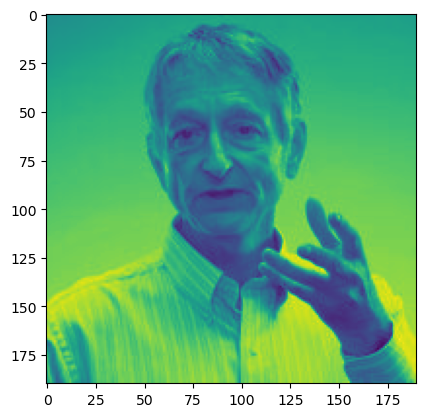

In [64]:
# OBJECT LOCALIZATION
# In Object Localization we locate the presence of objects in an image and indicate the location with a bounding box. Consider the image of Geoffrey Hinton

img_path='jeff_hinton.jpg'
half = 0.5
image = Image.open(img_path)

image.resize( [int(half * s) for s in image.size] )

plt.imshow(image)
plt.show()

In [65]:
# Create a transform object to convert the image to a tensor.

transform = transforms.Compose([transforms.ToTensor()])

In [66]:
# Convert the image to a tensor

img = transform(image)

In [67]:
# we can make a prediction,The output is a dictionary with several predicted classes, the probability of belonging to that class and the coordinates of the bounding box corresponding to that class.
pred = model([img])

# note: if you call model_([img]) directly but it will use more RAM 

In [68]:
# we have the 35 different class predictions, ordered by likelihood scores for potential objects.
pred[0]['labels']

tensor([ 1, 32, 32, 32, 32,  1])

In [69]:
# We have the likelihood of each class:

pred[0]['scores']

tensor([0.9995, 0.6251, 0.5832, 0.1829, 0.1187, 0.1073])

In [70]:
# Note here we use likelihood as a synonym for probability. Many neural networks output a probability of the output of being a specific class. Here the output is the confidence of prediction, so we use the term likelihood to distinguish between the two 
# The class number corresponds to the index of the list with the corresponding category name 
index=pred[0]['labels'][0].item()
COCO_INSTANCE_CATEGORY_NAMES[index]

'person'

In [71]:
# we have the coordinates of the bounding box
bounding_box=pred[0]['boxes'][0].tolist()
bounding_box

[0.0, 4.306368827819824, 185.40658569335938, 187.8170166015625]

In [72]:
# These components correspond to the top-left corner and bottom-right corner of the rectangle,more precisely :

# top (t),left (l),bottom(b),right (r)
# we need to round them
t, l, r, b=[round(x) for x in bounding_box]

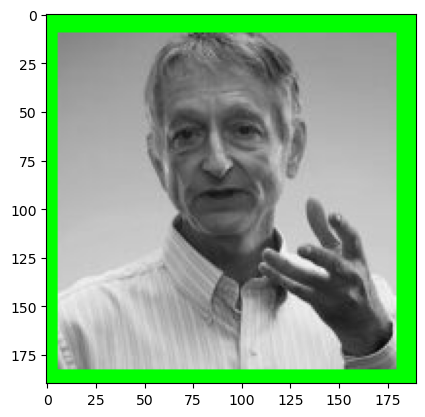

In [73]:
# convert the tensor to an open CV array and plot an image with the box:
img_plot=(np.clip(cv2.cvtColor(np.clip(img.numpy().transpose((1, 2, 0)),0,1), cv2.COLOR_RGB2BGR),0,1)*255).astype(np.uint8)
cv2.rectangle(img_plot, (t, l), (r, b), (0, 255, 0), 10) # Draw the rectangle with the coordinates
plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
plt.show()
del img_plot, t, l, r, b

In [74]:
# We can localize objects; we do this using the function get_predictions. The input is the predictions pred and the objects you would like to localize .
pred_class=get_predictions(pred,objects="person")
draw_box(pred_class, img)
del pred_class

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'rec'. Expected sequence length 4, got 2
>  - Can't parse 'rec'. Expected sequence length 4, got 2


In [75]:
get_predictions(pred,threshold=1,objects="person")

[]

In [76]:
pred_thresh=get_predictions(pred,threshold=0.98,objects="person")
draw_box(pred_thresh,img)
del pred_thresh

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'rec'. Expected sequence length 4, got 2
>  - Can't parse 'rec'. Expected sequence length 4, got 2
